<a href="https://colab.research.google.com/github/Adizcool/Next_Word_Predictor/blob/main/Next_Word_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq


In [2]:
text = open('1661-0.txt').read().lower()
print('corpus length:', len(text))


corpus length: 581888


In [3]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)


In [4]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))


In [5]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])


['project', 'gutenberg', 's', 'the', 'adventures']
of


In [6]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)


In [7]:
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1


In [8]:
print(X[0][0])


[False False False ... False False False]


In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))


In [10]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


811/811 [==============================] - 245s 300ms/step - loss: 6.0128 - accuracy: 0.1070 - val_loss: 7.0675 - val_accuracy: 0.1036
Epoch 2/20
811/811 [==============================] - 238s 294ms/step - loss: 5.7855 - accuracy: 0.1471 - val_loss: 7.9039 - val_accuracy: 0.1084
Epoch 3/20
811/811 [==============================] - 242s 298ms/step - loss: 5.7573 - accuracy: 0.1781 - val_loss: 7.9222 - val_accuracy: 0.1003
Epoch 4/20
811/811 [==============================] - 239s 295ms/step - loss: 5.4647 - accuracy: 0.2113 - val_loss: 8.2357 - val_accuracy: 0.0974
Epoch 5/20
811/811 [==============================] - 244s 301ms/step - loss: 5.1258 - accuracy: 0.2492 - val_loss: 8.4967 - val_accuracy: 0.0915
Epoch 6/20
811/811 [==============================] - 234s 289ms/step - loss: 4.7841 - accuracy: 0.2910 - val_loss: 8.7617 - val_accuracy: 0.0903
Epoch 7/20
811/811 [==============================] - 228s 281ms/step - loss: 4.4685 - accuracy: 0.3336 - val_loss: 8.8400 - val_accura

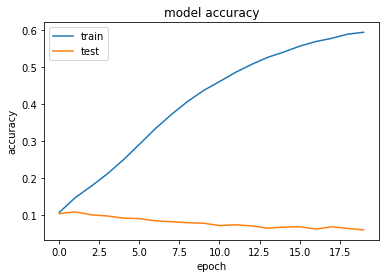

In [11]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

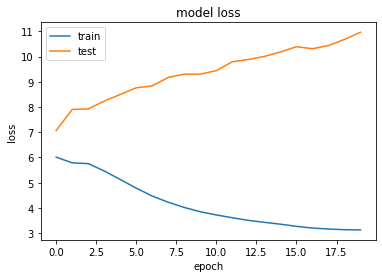

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [13]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))

model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))


In [14]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())


it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [15]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)


In [16]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [22]:
quotes = [
    "I came here to see you again.",
    "If it does not kill us makes us stronger.",
    "Are you heading back to the garden?"
]
for q in quotes:
  print("correct sentence: ",q)
  seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
  print("Sequence: ",seq)
  print("next possible words: ", predict_completions(seq, 5))


correct sentence:  I came here to see you again.
Sequence:  i came here to see
i
came
here
to
see
next possible words:  ['him', 'that', 'you', 'out', 'upon']
correct sentence:  If it does not kill us makes us stronger.
Sequence:  if it does not kill
if
it
does
not
kill
next possible words:  ['your', 'to', 'her', 'there', 'his']
correct sentence:  Are you heading back to the garden?
Sequence:  are you heading back to
are
you
heading
back
to
next possible words:  ['a', 'the', 'see', 'this', 'his']
